**TM10007 Machine Learning**

## Import dependencies and data

In [85]:
import os
import zipfile
import pandas as pd
import numpy as np
import shutil
import subprocess
import shutil
import os
import stat
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from os import path
from sklearn import model_selection
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, fbeta_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.utils import resample

## if data.csv is not present download it from github
if not os.path.isfile("ecg_data.csv"):
    ## clone repo from githun
    if not os.path.isdir("tm10007_ml"):
        !git clone https://github.com/jveenland/tm10007_ml.git
    ## extract zip file
    if not os.path.isfile("tm10007_ml/ecg/ecg_data.csv"):
        with zipfile.ZipFile('tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
            zip_ref.extractall('tm10007_ml/ecg')
    ## move data file to root folder
    shutil.move('tm10007_ml/ecg/ecg_data.csv', 'ecg_data.csv')

    ## Delete cloned repo
    for root, dirs, files in os.walk("./tm10007_ml"):  
        for dir in dirs:
            os.chmod(path.join(root, dir), stat.S_IRWXU)
        for file in files:
            os.chmod(path.join(root, file), stat.S_IRWXU)
    shutil.rmtree('./tm10007_ml')

data = pd.read_csv('ecg_data.csv', index_col=0)

## Inspect imported data and clean missing data

### Plot number of missing data per features and per patient

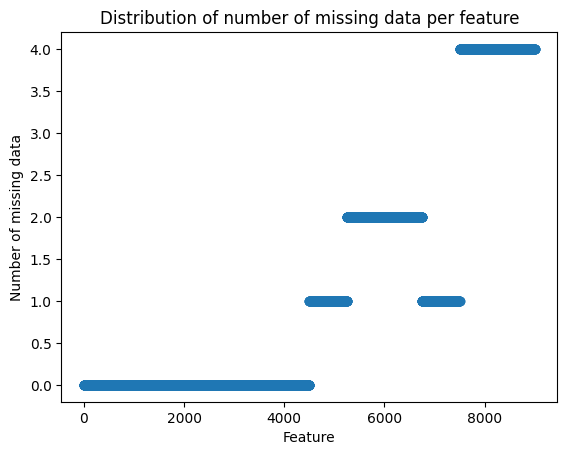

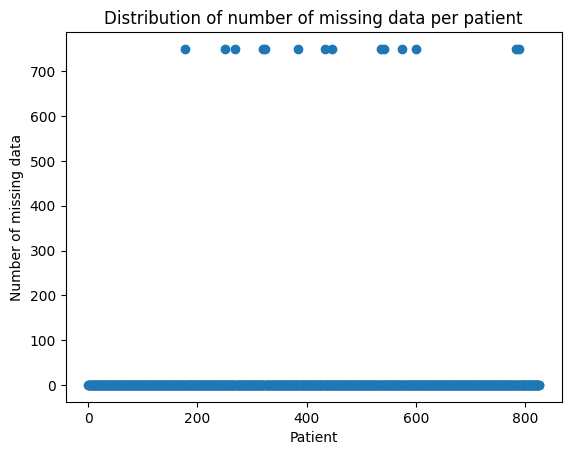

In [86]:
# exclude label column
values_features = data.drop(['label'], axis=1)

# plot the distribution of missing data per feature
num_zeros_features = (values_features == 0).sum(axis=0)
plt.scatter(range(len(num_zeros_features)),num_zeros_features)
plt.title("Distribution of number of missing data per feature")
plt.ylabel('Number of missing data')
plt.xlabel('Feature')
plt.show()

# plot the distribution of missing data per patient
num_zeros_patients=(values_features == 0).sum(axis=1)
plt.scatter(range(len(num_zeros_patients)),num_zeros_patients)
plt.title("Distribution of number of missing data per patient")
plt.ylabel('Number of missing data')
plt.xlabel('Patient')
plt.show()

### Delete rows with missing data

In [87]:
values_data = data.drop(['label'], axis=1)
mask = (values_data != 0).all(axis=1)
clean_data=data[mask]
dirty_data=data[~mask]

### Plot number of missing data per features and per patient after data cleanup

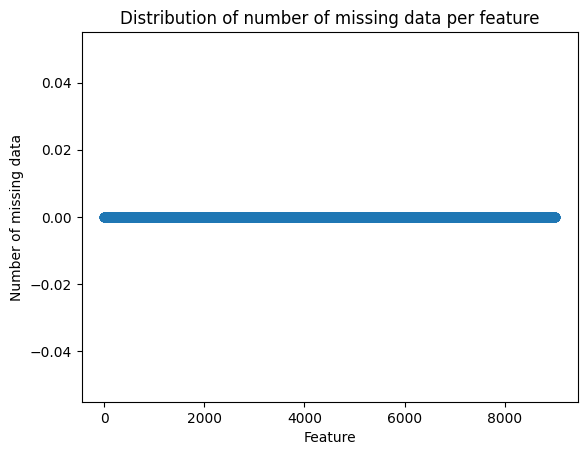

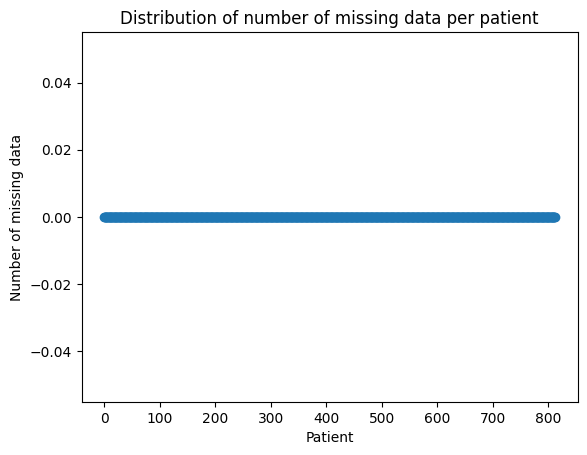

In [88]:
# exclude label column
values_clean_data = clean_data.drop(['label'], axis=1)
# plot the distribution of missing data per feature
num_zeros_features = (values_clean_data == 0).sum(axis=0)
plt.scatter(range(len(num_zeros_features)),num_zeros_features)
plt.title("Distribution of number of missing data per feature")
plt.ylabel('Number of missing data')
plt.xlabel('Feature')
plt.show()

# plot the distribution of missing data per patient
num_zeros_patients=(values_clean_data == 0).sum(axis=1)
plt.scatter(range(len(num_zeros_patients)),num_zeros_patients)
plt.title("Distribution of number of missing data per patient")
plt.ylabel('Number of missing data')
plt.xlabel('Patient')
plt.show()

## Split data into test and train data

In [89]:
ECG_ABNORMAL = data[data['label'] == 1]
ECG_NORMAL = data[data['label'] == 0]

x_train_abnormal, x_test_abnormal = model_selection.train_test_split(ECG_ABNORMAL, test_size=0.2, random_state=30)
x_train_normal, x_test_normal = model_selection.train_test_split(ECG_NORMAL,test_size = 0.2,random_state=30)

train_set = pd.concat([x_train_normal,x_train_abnormal])
test_set = pd.concat([x_test_normal,x_test_abnormal])

ECG_TRAIN_ABNORMAL = train_set[train_set['label'] == 1]
ECG_TRAIN_NORMAL = train_set[train_set['label'] == 0]

ECG_TRAIN_DOWNSAMPLED = resample(ECG_TRAIN_NORMAL,
                                      replace=False,
                                      n_samples=len(ECG_TRAIN_ABNORMAL),
                                      random_state=30)

# Concat normal and abnormal
train_set_downsampled = pd.concat([ECG_TRAIN_ABNORMAL, ECG_TRAIN_DOWNSAMPLED])

# Shuffle
train_set = train_set_downsampled.sample(frac=1, random_state=30)

## Scale features of train and test set

In [90]:
# deal with outliers in the data
transformer = RobustScaler().fit(train_set)
train_set_robust = pd.DataFrame(transformer.transform(train_set))
test_set_robust = pd.DataFrame(transformer.transform(test_set))

# scaling the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
# fit the scaler on the train set
scaler.fit(train_set_robust)
# transform both train and test data set with the scaler
# rename the column names to the ones from 'data' again
train_set_scaled = pd.DataFrame(scaler.transform(train_set))
train_set_scaled.columns=data.columns.values
test_set_scaled = pd.DataFrame(scaler.transform(test_set))
test_set_scaled.columns=data.columns.values

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [91]:
# scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
# fit the scaler on the train set
scaler.fit(train_set)
# transform both train and test data set with the scaler
# rename the column names to the ones from 'data' again
train_set_scaled = pd.DataFrame(scaler.transform(train_set))
train_set_scaled.columns=data.columns.values
test_set_scaled = pd.DataFrame(scaler.transform(test_set))
test_set_scaled.columns=data.columns.values

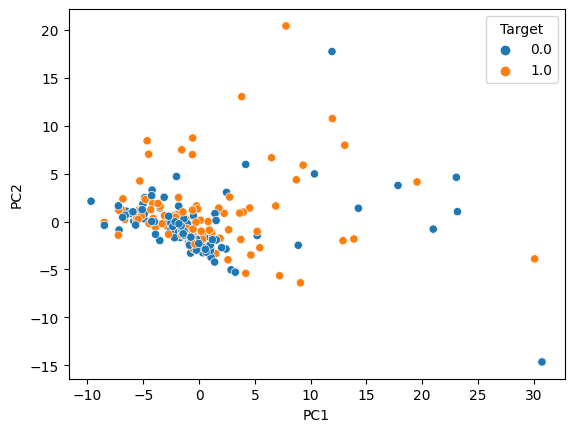

[0.23002791 0.07535677]


In [92]:
x = train_set_scaled.iloc[:, :-1].values
y = train_set_scaled.iloc[:, -1].values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x)

df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Target'] = y

sns.scatterplot(x='PC1', y='PC2', hue='Target', data=df_pca)
plt.show()

print(pca.explained_variance_ratio_)

In [93]:
# Colorplot
def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.
    
    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    features = np.c_[xx.ravel(), yy.ravel()]
    if precomputer is not None:
        if type(precomputer) is RBFSampler:
            features = precomputer.transform(features)
        elif precomputer is rbf_kernel:
            features = rbf_kernel(features, X)
            
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(features)
    elif hasattr(clf, "predict_proba"):
        Z = clf.predict_proba(features)
    else:
        Z = clf.predict(features)
        
    if len(Z.shape) > 1:
        Z = Z[:, 1]
    
    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

The mean accuracy score of the classifier is: 0.50
The mean precision score of the classifier is: 0.51
The mean recall score of the classifier is: 0.47
The mean F1 score of the classifier is: 0.49
The mean weighted F1 score of the classifier is: 0.48


Text(0.5, 1.0, 'Correctly classified by KNN classifier: 50.45%')

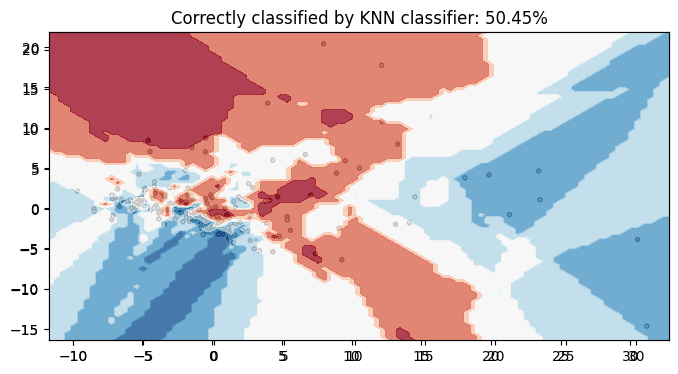

In [94]:
# KNN classifier
knn = KNeighborsClassifier()
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
knn.fit(X_pca,y)
ax = fig.add_subplot()
ax.scatter(X_pca[:,0],X_pca[:,1],marker='o',c=y,s=8,edgecolor='k',cmap=plt.cm.Paired)
colorplot(knn, ax, X_pca[:,0], X_pca[:,1])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

# Compute the accuracy of the classifier
accuracy_scores = cross_val_score(knn, X_pca, y, cv=cv, scoring='accuracy')
mean_accuracy_score = accuracy_scores.mean()
print("The mean accuracy score of the classifier is: {:.2f}".format(mean_accuracy_score))

# Compute the precision of the classifier
precision_scores = cross_val_score(knn, X_pca, y, cv=cv, scoring='precision')
mean_precision_score = precision_scores.mean()
print("The mean precision score of the classifier is: {:.2f}".format(mean_precision_score))

# Compute the recall of the classifier
recall_scores = cross_val_score(knn, X_pca, y, cv=cv, scoring='recall')
mean_recall_score = recall_scores.mean()
print("The mean recall score of the classifier is: {:.2f}".format(mean_recall_score))

# Compute the F1 score of the classifier
f1_scores = cross_val_score(knn, X_pca, y, cv=cv, scoring='f1')
mean_f1_score = f1_scores.mean()
print("The mean F1 score of the classifier is: {:.2f}".format(mean_f1_score))

# Compute the weighted F1 score of the classifier
fbeta_scorer = make_scorer(fbeta_score, beta=2)
fbeta_scores = cross_val_score(knn, X_pca, y, cv=cv, scoring=fbeta_scorer)
mean_fbeta_score = fbeta_scores.mean()
print("The mean weighted F1 score of the classifier is: {:.2f}".format(mean_fbeta_score))

mean_accuracy_score_rounded = "{:.2f}".format(mean_accuracy_score*100)
t = "Correctly classified by KNN classifier: " + mean_accuracy_score_rounded + "%"
ax.set_title(t)

The mean accuracy score of the classifier is: 0.54
The mean precision score of the classifier is: 0.59
The mean recall score of the classifier is: 0.30
The mean F1 score of the classifier is: 0.39
The mean weighted F1 score of the classifier is: 0.33


Text(0.5, 1.0, 'Correctly classified by QDA classifier: 54.32%')

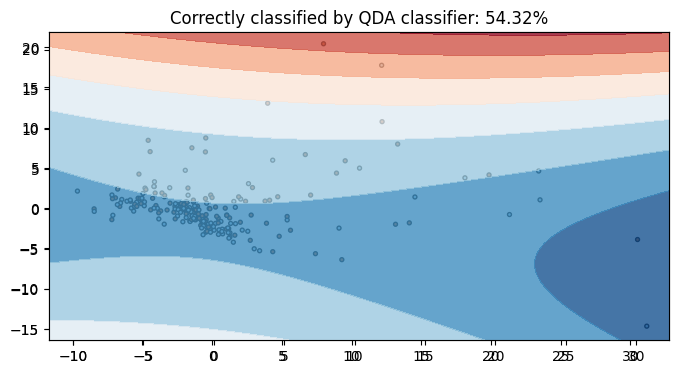

In [95]:
# Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis()
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
qda.fit(X_pca,y)
ax = fig.add_subplot()
ax.scatter(X_pca[:,0],X_pca[:,1],marker='o',c=y,s=8,edgecolor='k',cmap=plt.cm.Paired)
colorplot(qda, ax, X_pca[:,0], X_pca[:,1])

# Compute the accuracy of the classifier
accuracy_scores = cross_val_score(qda, X_pca, y, cv=cv, scoring='accuracy')
mean_accuracy_score = accuracy_scores.mean()
print("The mean accuracy score of the classifier is: {:.2f}".format(mean_accuracy_score))

# Compute the precision of the classifier
precision_scores = cross_val_score(qda, X_pca, y, cv=cv, scoring='precision')
mean_precision_score = precision_scores.mean()
print("The mean precision score of the classifier is: {:.2f}".format(mean_precision_score))

# Compute the recall of the classifier
recall_scores = cross_val_score(qda, X_pca, y, cv=cv, scoring='recall')
mean_recall_score = recall_scores.mean()
print("The mean recall score of the classifier is: {:.2f}".format(mean_recall_score))

# Compute the F1 score of the classifier
f1_scores = cross_val_score(qda, X_pca, y, cv=cv, scoring='f1')
mean_f1_score = f1_scores.mean()
print("The mean F1 score of the classifier is: {:.2f}".format(mean_f1_score))

# Compute the weighted F1 score of the classifier
fbeta_scorer = make_scorer(fbeta_score, beta=2)
fbeta_scores = cross_val_score(qda, X_pca, y, cv=cv, scoring=fbeta_scorer)
mean_fbeta_score = fbeta_scores.mean()
print("The mean weighted F1 score of the classifier is: {:.2f}".format(mean_fbeta_score))

mean_accuracy_score_rounded = "{:.2f}".format(mean_accuracy_score*100)
t = "Correctly classified by QDA classifier: " + mean_accuracy_score_rounded + "%"
ax.set_title(t)

The mean accuracy score of the classifier is: 0.53
The mean precision score of the classifier is: 0.59
The mean recall score of the classifier is: 0.29
The mean F1 score of the classifier is: 0.37
The mean weighted F1 score of the classifier is: 0.31


Text(0.5, 1.0, 'Correctly classified by Gaussian classifier: 53.48%')

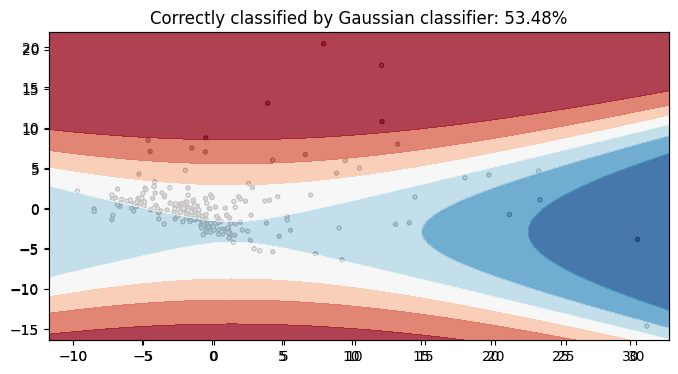

In [96]:
# Gaussian
gauss = GaussianNB()
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
gauss.fit(X_pca,y)
ax = fig.add_subplot()
ax.scatter(X_pca[:,0],X_pca[:,1],marker='o',c=y,s=8,edgecolor='k',cmap=plt.cm.Paired)
colorplot(gauss, ax, X_pca[:,0], X_pca[:,1])

# Compute the accuracy of the classifier
accuracy_scores = cross_val_score(gauss, X_pca, y, cv=cv, scoring='accuracy')
mean_accuracy_score = accuracy_scores.mean()
print("The mean accuracy score of the classifier is: {:.2f}".format(mean_accuracy_score))

# Compute the precision of the classifier
precision_scores = cross_val_score(gauss, X_pca, y, cv=cv, scoring='precision')
mean_precision_score = precision_scores.mean()
print("The mean precision score of the classifier is: {:.2f}".format(mean_precision_score))

# Compute the recall of the classifier
recall_scores = cross_val_score(gauss, X_pca, y, cv=cv, scoring='recall')
mean_recall_score = recall_scores.mean()
print("The mean recall score of the classifier is: {:.2f}".format(mean_recall_score))

# Compute the F1 score of the classifier
f1_scores = cross_val_score(gauss, X_pca, y, cv=cv, scoring='f1')
mean_f1_score = f1_scores.mean()
print("The mean F1 score of the classifier is: {:.2f}".format(mean_f1_score))

# Compute the weighted F1 score of the classifier
fbeta_scorer = make_scorer(fbeta_score, beta=2)
fbeta_scores = cross_val_score(gauss, X_pca, y, cv=cv, scoring=fbeta_scorer)
mean_fbeta_score = fbeta_scores.mean()
print("The mean weighted F1 score of the classifier is: {:.2f}".format(mean_fbeta_score))

mean_accuracy_score_rounded = "{:.2f}".format(mean_accuracy_score*100)
t = "Correctly classified by Gaussian classifier: " + mean_accuracy_score_rounded + "%"
ax.set_title(t)

The mean accuracy score of the classifier is: 0.60
The mean precision score of the classifier is: 0.65
The mean recall score of the classifier is: 0.47
The mean F1 score of the classifier is: 0.53
The mean weighted F1 score of the classifier is: 0.49


Text(0.5, 1.0, 'Correctly classified by SVM RBF classifier: 59.50%')

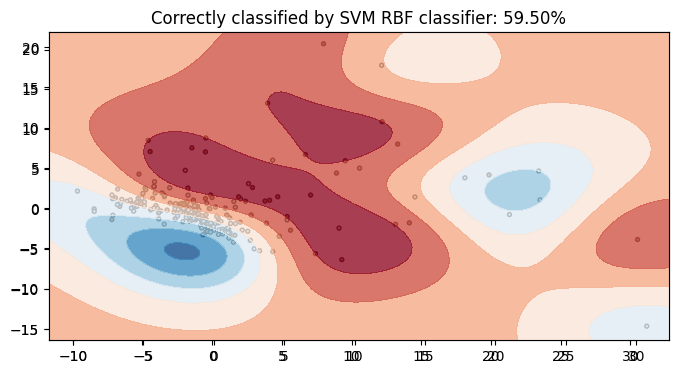

In [97]:
# SVM RBF
svmrbf = SVC(kernel='rbf', gamma='scale')
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
svmrbf.fit(X_pca,y)
ax = fig.add_subplot()
ax.scatter(X_pca[:,0],X_pca[:,1],marker='o',c=y,s=8,edgecolor='k',cmap=plt.cm.Paired)
colorplot(svmrbf, ax, X_pca[:,0], X_pca[:,1])

# Compute the accuracy of the classifier
accuracy_scores = cross_val_score(svmrbf, X_pca, y, cv=cv, scoring='accuracy')
mean_accuracy_score = accuracy_scores.mean()
print("The mean accuracy score of the classifier is: {:.2f}".format(mean_accuracy_score))

# Compute the precision of the classifier
precision_scores = cross_val_score(svmrbf, X_pca, y, cv=cv, scoring='precision')
mean_precision_score = precision_scores.mean()
print("The mean precision score of the classifier is: {:.2f}".format(mean_precision_score))

# Compute the recall of the classifier
recall_scores = cross_val_score(svmrbf, X_pca, y, cv=cv, scoring='recall')
mean_recall_score = recall_scores.mean()
print("The mean recall score of the classifier is: {:.2f}".format(mean_recall_score))

# Compute the F1 score of the classifier
f1_scores = cross_val_score(svmrbf, X_pca, y, cv=cv, scoring='f1')
mean_f1_score = f1_scores.mean()
print("The mean F1 score of the classifier is: {:.2f}".format(mean_f1_score))

# Compute the weighted F1 score of the classifier
fbeta_scorer = make_scorer(fbeta_score, beta=2)
fbeta_scores = cross_val_score(svmrbf, X_pca, y, cv=cv, scoring=fbeta_scorer)
mean_fbeta_score = fbeta_scores.mean()
print("The mean weighted F1 score of the classifier is: {:.2f}".format(mean_fbeta_score))

mean_accuracy_score_rounded = "{:.2f}".format(mean_accuracy_score*100)
t = "Correctly classified by SVM RBF classifier: " + mean_accuracy_score_rounded + "%"
ax.set_title(t)

The mean accuracy score of the classifier is: 0.50
The mean precision score of the classifier is: 0.46
The mean recall score of the classifier is: 0.24
The mean F1 score of the classifier is: 0.21
The mean weighted F1 score of the classifier is: 0.22


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Correctly classified by SVM polynomial classifier: 50.46%')

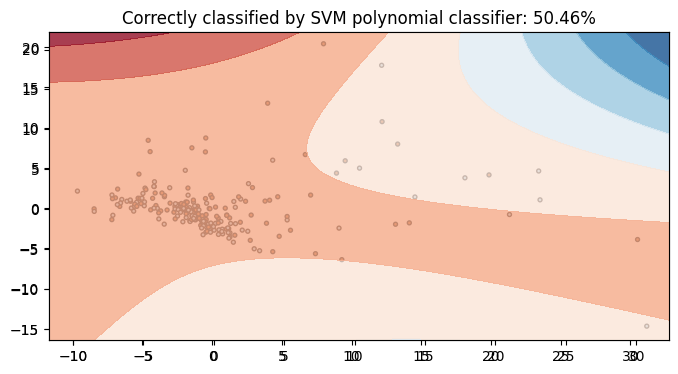

In [98]:
# SVM polynomial
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
svmpoly.fit(X_pca,y)
ax = fig.add_subplot()
ax.scatter(X_pca[:,0],X_pca[:,1],marker='o',c=y,s=8,edgecolor='k',cmap=plt.cm.Paired)
colorplot(svmpoly, ax, X_pca[:,0], X_pca[:,1])

# Compute the accuracy of the classifier
accuracy_scores = cross_val_score(svmpoly, X_pca, y, cv=cv, scoring='accuracy')
mean_accuracy_score = accuracy_scores.mean()
print("The mean accuracy score of the classifier is: {:.2f}".format(mean_accuracy_score))

# Compute the precision of the classifier
precision_scores = cross_val_score(svmpoly, X_pca, y, cv=cv, scoring='precision')
mean_precision_score = precision_scores.mean()
print("The mean precision score of the classifier is: {:.2f}".format(mean_precision_score))

# Compute the recall of the classifier
recall_scores = cross_val_score(svmpoly, X_pca, y, cv=cv, scoring='recall')
mean_recall_score = recall_scores.mean()
print("The mean recall score of the classifier is: {:.2f}".format(mean_recall_score))

# Compute the F1 score of the classifier
f1_scores = cross_val_score(svmpoly, X_pca, y, cv=cv, scoring='f1')
mean_f1_score = f1_scores.mean()
print("The mean F1 score of the classifier is: {:.2f}".format(mean_f1_score))

# Compute the weighted F1 score of the classifier
fbeta_scorer = make_scorer(fbeta_score, beta=2)
fbeta_scores = cross_val_score(svmpoly, X_pca, y, cv=cv, scoring=fbeta_scorer)
mean_fbeta_score = fbeta_scores.mean()
print("The mean weighted F1 score of the classifier is: {:.2f}".format(mean_fbeta_score))

mean_accuracy_score_rounded = "{:.2f}".format(mean_accuracy_score*100)
t = "Correctly classified by SVM polynomial classifier: " + mean_accuracy_score_rounded + "%"
ax.set_title(t)

The mean accuracy score of the classifier is: 0.50
The mean precision score of the classifier is: 0.51
The mean recall score of the classifier is: 0.47
The mean F1 score of the classifier is: 0.45
The mean weighted F1 score of the classifier is: 0.47


Text(0.5, 1.0, 'Correctly classified by decision tree classifier: 49.56%')

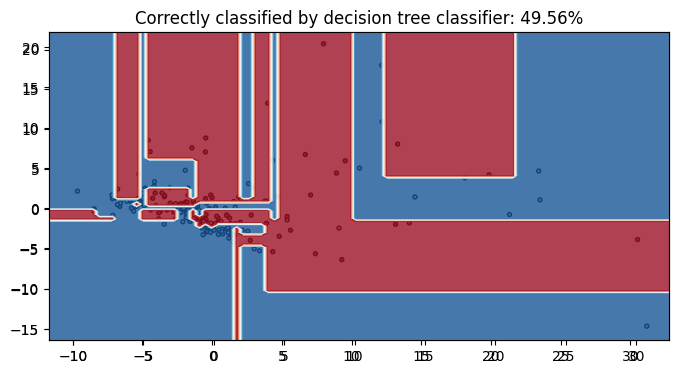

In [99]:
# Decision tree classifier
decision_tree = DecisionTreeClassifier()
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
decision_tree.fit(X_pca,y)
ax = fig.add_subplot()
ax.scatter(X_pca[:,0],X_pca[:,1],marker='o',c=y,s=8,edgecolor='k',cmap=plt.cm.Paired)
colorplot(decision_tree, ax, X_pca[:,0], X_pca[:,1])

# Compute the accuracy of the classifier
accuracy_scores = cross_val_score(decision_tree, X_pca, y, cv=cv, scoring='accuracy')
mean_accuracy_score = accuracy_scores.mean()
print("The mean accuracy score of the classifier is: {:.2f}".format(mean_accuracy_score))

# Compute the precision of the classifier
precision_scores = cross_val_score(decision_tree, X_pca, y, cv=cv, scoring='precision')
mean_precision_score = precision_scores.mean()
print("The mean precision score of the classifier is: {:.2f}".format(mean_precision_score))

# Compute the recall of the classifier
recall_scores = cross_val_score(decision_tree, X_pca, y, cv=cv, scoring='recall')
mean_recall_score = recall_scores.mean()
print("The mean recall score of the classifier is: {:.2f}".format(mean_recall_score))

# Compute the F1 score of the classifier
f1_scores = cross_val_score(decision_tree, X_pca, y, cv=cv, scoring='f1')
mean_f1_score = f1_scores.mean()
print("The mean F1 score of the classifier is: {:.2f}".format(mean_f1_score))

# Compute the weighted F1 score of the classifier
fbeta_scorer = make_scorer(fbeta_score, beta=2)
fbeta_scores = cross_val_score(decision_tree, X_pca, y, cv=cv, scoring=fbeta_scorer)
mean_fbeta_score = fbeta_scores.mean()
print("The mean weighted F1 score of the classifier is: {:.2f}".format(mean_fbeta_score))

mean_accuracy_score_rounded = "{:.2f}".format(mean_accuracy_score*100)
t = "Correctly classified by decision tree classifier: " + mean_accuracy_score_rounded + "%"
ax.set_title(t)

The mean accuracy score of the classifier is: 0.51
The mean precision score of the classifier is: 0.50
The mean recall score of the classifier is: 0.52
The mean F1 score of the classifier is: 0.51
The mean weighted F1 score of the classifier is: 0.52


Text(0.5, 1.0, 'Correctly classified by random forest classifier: 50.87%')

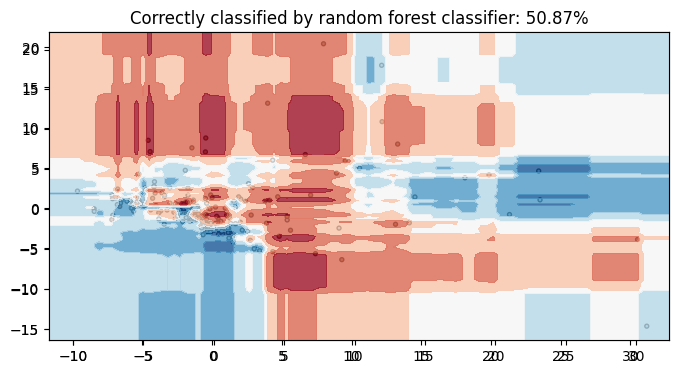

In [100]:
# Random forest classifier
random_forest = RandomForestClassifier()
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
random_forest.fit(X_pca,y)
ax = fig.add_subplot()
ax.scatter(X_pca[:,0],X_pca[:,1],marker='o',c=y,s=8,edgecolor='k',cmap=plt.cm.Paired)
colorplot(random_forest, ax, X_pca[:,0], X_pca[:,1])

# Compute the accuracy of the classifier
accuracy_scores = cross_val_score(random_forest, X_pca, y, cv=cv, scoring='accuracy')
mean_accuracy_score = accuracy_scores.mean()
print("The mean accuracy score of the classifier is: {:.2f}".format(mean_accuracy_score))

# Compute the precision of the classifier
precision_scores = cross_val_score(random_forest, X_pca, y, cv=cv, scoring='precision')
mean_precision_score = precision_scores.mean()
print("The mean precision score of the classifier is: {:.2f}".format(mean_precision_score))

# Compute the recall of the classifier
recall_scores = cross_val_score(random_forest, X_pca, y, cv=cv, scoring='recall')
mean_recall_score = recall_scores.mean()
print("The mean recall score of the classifier is: {:.2f}".format(mean_recall_score))

# Compute the F1 score of the classifier
f1_scores = cross_val_score(random_forest, X_pca, y, cv=cv, scoring='f1')
mean_f1_score = f1_scores.mean()
print("The mean F1 score of the classifier is: {:.2f}".format(mean_f1_score))

# Compute the weighted F1 score of the classifier
fbeta_scorer = make_scorer(fbeta_score, beta=2)
fbeta_scores = cross_val_score(random_forest, X_pca, y, cv=cv, scoring=fbeta_scorer)
mean_fbeta_score = fbeta_scores.mean()
print("The mean weighted F1 score of the classifier is: {:.2f}".format(mean_fbeta_score))

mean_accuracy_score_rounded = "{:.2f}".format(mean_accuracy_score*100)
t = "Correctly classified by random forest classifier: " + mean_accuracy_score_rounded + "%"
ax.set_title(t)